In [315]:
import numpy as np
import theano
import theano.tensor as T
import network_components
import network_optimizers
from senti_net import network
import cPickle
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
% matplotlib inline

# Load the data

In [7]:
# Load in the data

start = time.time()
with open('./data/ready_data_840B_300d.pkl', 'r') as f:
    data_dict = cPickle.load(f)
    
dur = time.time() - start
print dur

133.311171055


## Plotting functions

In [314]:
# Frequently used plotting functions

def smooth_rep(data,sigma):
    w = np.ceil(2*sigma)
    f = np.exp( -.5*(np.arange(-w,w)**2)/(sigma**2) )
    f = f / np.sum(f)
    
    for rnds in range(3):
        for i in range(len(data)-1):
            if np.isinf(data[i]) or np.isnan(data[i]):
                data[i]=data[i+1]

    y = np.convolve(data,f,'valid')
    x = np.arange(w,len(data)-w+1)
    return x, y


def box_rep(data, sz):
    x = np.arange(float(len(data)))
    x_cs = np.cumsum(x)
    y_cs = np.cumsum(data)
    return (x_cs[sz:] - x_cs[:-sz]) / sz, (y_cs[sz:] - y_cs[:-sz]) / sz


def plot_cost(ax, cost_history, start=0, smooth_sigma=50, max_y = 250., skip=1):
    l = len(cost_history)
    assert l >= start
    c = cost_history[start:]
    
    c = c[::skip]
    l = len(c)
    
    smooth_sigma = np.minimum(smooth_sigma, np.ceil(len(c)/2.))
    
    # Plot the dooder with all the points
    ax[0].cla()
    ax[0].plot(start+(np.arange(l)*skip), c, '.');
    if l > smooth_sigma:
        smth_x, smth_y = box_rep(c, smooth_sigma/skip)
        smth_x = start + (smth_x*skip)
        ax[0].plot(smth_x, smth_y, 'r', linewidth=3)
        
        smooth_sigma = int(smooth_sigma)
        
        max_dat = np.max(c)
        y_cand = np.minimum(max_y, max_dat)
        ax[0].set_ylim([np.maximum(-500,np.min(c)-.2),
                        np.minimum(3000,np.maximum(y_cand, .2+np.max(c[-smooth_sigma:])))])
    else:
        ax[0].set_ylim([np.maximum(-500,np.min(c)-.2),
                        np.minimum(3000,np.minimum(2000, np.max(c)+.2))])
    
    ax[0].grid(axis='y')
    ax[0].set_xlim([start, start+(skip*l)])
    
    # Provide a visualization of just the smoothed one
    if l > smooth_sigma:
        ax[1].cla()
        ax[1].plot(smth_x, smth_y, 'r', linewidth=3)
        xs = [start, start+(skip*l)]
        ax[1].plot(xs,[smth_y[-1], smth_y[-1]], 'k')
        ax[1].set_xlim(xs)
        ax[1].grid(axis='y')
    
    
def plot_pcs(ax_pair_list_or_fig, pc_pairs, labels, ys, n_back=100, cmap='nipy_spectral', bg=.5):
    # pc_pairs must be a list of pairs (where each pair is expressed as a list)
    assert type(pc_pairs) == list
    for pair in pc_pairs:
        assert len(pair)==2
    n_pairs = len(pc_pairs)
    
    if type(ax_pair_list_or_fig) == list:
        # Assume a list of axes, set up in the same way as pc_pairs
        for pair in ax_pair_list_or_fig:
            assert len(pair)==2
        assert len(ax_pair_list_or_fig)==n_pairs
        ax_list = ax_pair_list_or_fig
    else:
        # Assume an empty figure object. Fill it with sub axes to match pc_pairs
        fig = ax_pair_list_or_fig
        ax_list = []
        for i in range(n_pairs):
            ax_list += [[fig.add_subplot(n_pairs, 2, j+1+(2*i)) for j in range(2)]]
    
    if ys.shape[2] > 1:
        # Get your PCs and their projections
        l = labels[:, -n_back:].flatten()
        y = ys[:, :, -n_back:]
        y = np.vstack([y[:,i,:].flatten() for i in range(y.shape[1])])
        eD, eV = np.linalg.eig(np.cov(y))
        eV = eV * np.sign(eV[0,])
        proj = np.dot(eV.T, y)

        # Step through each axis/pc pair and plot them
        cmap = plt.get_cmap(cmap)
        for ax_pc_pair in zip(ax_list, pc_pairs):
            # Unpack
            axs = ax_pc_pair[0]
            pcs = ax_pc_pair[1]
            for ax in axs: ax.cla()
            # Alternately plot the points for each digit
            for i, cidx in enumerate(np.linspace(0, 256, 10)):
                idx = l==i
                axs[(i%2)].plot(proj[pcs[0],idx], proj[pcs[1],idx], '.', c=cmap(int(cidx)), markersize=10);
            # Apply the desired background color
            for ax in axs:
                ax.set_axis_bgcolor(bg*np.ones(3))
            axs[0].set_ylabel("{} vs {}".format(pcs[0], pcs[1]))


def open_scatter(ax, indices, s=160, c='k', w=3):
    return ax.scatter(indices%20, np.floor(indices/20), s=s, edgecolor=c, linewidths=w, facecolor='none')

def plot_acc(ax, acc, eval_interval, start_at=0, xlim=None):
    """
    Plot accuracy
    
    Parameters
    ----------
    ax: matplotlib axis handle
    acc: a list of accuracies, sampled at a consistent interval
    eval_interval: integer, the accuracy sampling interval
    start_at: the earliest time (in training iterations) to display
    xlim: x-axis limit of the plot
    """
    # Figure out the best index to start from
    i_start = int(np.ceil(start_at/float(eval_interval)))
    
    # Trim the data to this interval
    acc_plot = acc[i_start:]
    # Make the appropriate x-data for this
    xdata = (np.arange(i_start, len(acc))+1)*eval_interval
    
    ax.cla()
    ax.plot(xdata, acc_plot, 'o')
    
    if xlim is None:
        xlim = [xdata[0]-eval_interval, xdata[-1]+eval_interval]
    
    if len(acc_plot) >= 2:
        # Apply vanilla linear regression to visualize the trend
        xt = xdata-np.mean(xdata)
        y  = np.array(acc_plot)
        yt = y-np.mean(y)
        r = (yt.dot(xt)) / (xt.dot(xt))
        o = np.mean(y)

        rx = (np.array(xlim)-np.mean(xdata))*r + o
        ax.plot(xlim, rx, 'k-')
    
    ax.grid(axis='y')
    ax.set_xlim(xlim)

# Training routine:

In [316]:
def train_do(network, no_improve_limit, plot_every=10, plot_window=None, smooth_sigma=250):
    if plot_window is None:
        plot_window = no_improve_limit
    
    # Ready the figure
    fig = plt.figure(figsize=(15, 10))
    ax1_2 = [fig.add_subplot(3,1,1), fig.add_subplot(3,1,2)];
    ax3 = fig.add_subplot(3,1,3);
    
    # Apply a number of training rounds
    while network.no_improve_count <= no_improve_limit:

        # Pull data
        i_seq, s_len, t, _ = network.pull_data(data_dict['train'])

        network.adam_helpers(i_seq, s_len, t)
        this_cost = network.adam_train(i_seq, s_len, t)

        # Log
        network.cost_each_step += [this_cost]

        # Check dev accuracy
        if (len(network.cost_each_step) % network.eval_dev_every) == 0:
            this_acc = network.check_accuracy(data_dict['dev'])
            network.dev_acc += [this_acc]
            if this_acc > network.best_dev_acc:
                network.no_improve_count = 0
                network.best_dev_acc = this_acc
                network.best_dev_idx = len(network.cost_each_step)
                network.best_dev_tup = network.snapshot()
            else:
                network.no_improve_count += 1

        # Plot
        start_at = np.maximum(0, len(network.cost_each_step)-plot_window)
        if (len(network.cost_each_step) % plot_every) == 0:
            plot_cost(ax1_2, network.cost_each_step, start=start_at, skip=1, smooth_sigma=250, max_y=1.3)

            plot_acc(ax3, network.dev_acc, network.eval_dev_every, start_at, xlim=ax1_2[0].get_xlim())
            ylim = ax3.get_ylim()
            ax3.plot([network.best_dev_idx, network.best_dev_idx], ylim, 'r-')
            ax3.set_ylim(ylim)

            display.clear_output(wait=True)
            display.display(fig)

    network.end_of_train_tup = network.snapshot()

## Evaluation:

In [291]:
def full_eval(network, baseline_mean, baseline_std):
    # Check performance at the point in training with the best dev performance
    network.restore(network.best_dev_tup)
    print 'At best Dev performance...'
    print '\nTrain accuracy (appoximate): '
    network.check_accuracy(data_dict['train'], 2000);
    print '\nDev accuracy: '
    network.check_accuracy(data_dict['dev']);
    print '\nTest accuracy: '
    network.check_accuracy(data_dict['test']);
    
    # Check the performance at the termination of training
    network.restore(network.end_of_train_tup)
    print '\n\nAt end of training...'
    print '\nTrain accuracy (appoximate): '
    network.check_accuracy(data_dict['train'], 2000);
    print '\nDev accuracy: '
    network.check_accuracy(data_dict['dev']);
    print '\nTest accuracy: '
    a = 100.*network.check_accuracy(data_dict['test']);

    # Compare to the goal
    print '\n\nProbability this score beats Sheng Tai baseline:'
    print '{}%'.format(
        100.*np.round(1000.*np.mean(np.random.normal(baseline_mean, baseline_std, 10000) < a))/1000.)

# 1-layer vanilla LSTM

In [267]:
# Build a 1-layer vanilla LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(168, 0.5)]

# Build the LSTM "stack"
S = network_components.LSTM_stack(inp_dim, layer_specs, inp_dropout)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.single_class_sigmoid(S.out_dim)

# Create the network
net_LSTM_1_binary = network(S, O, bi_flag=False, fine_grained=False, batch_size=25, eval_dev_every=50, alpha=0.005)

17.6389200687


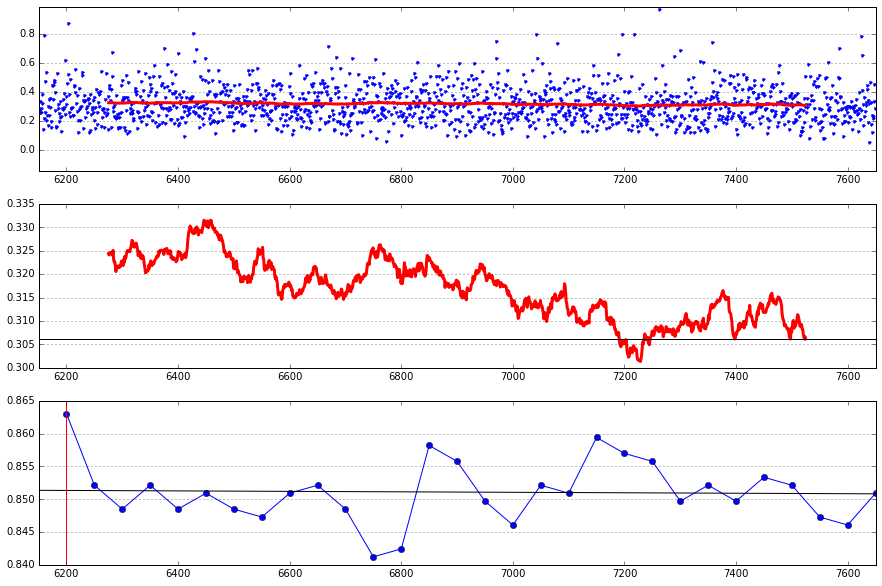

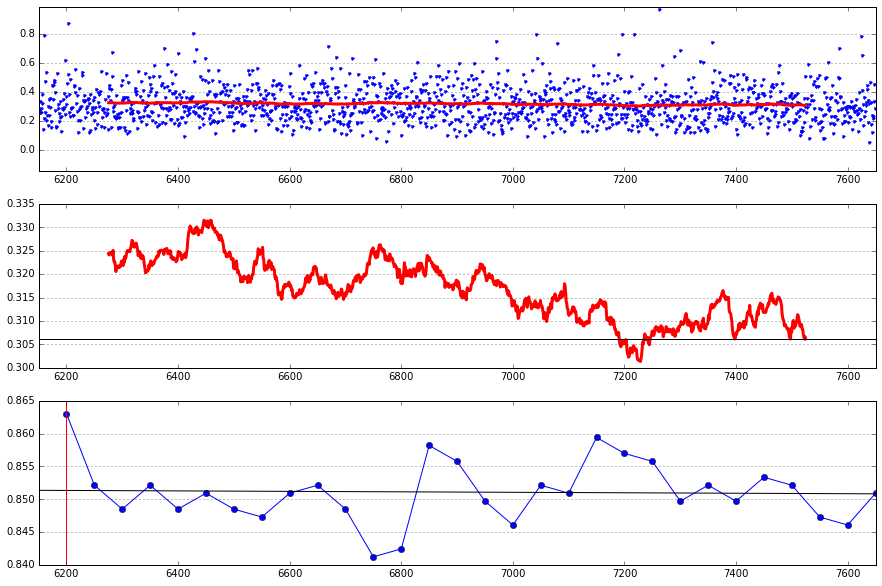

In [270]:
# Train it
train_do(net_LSTM_1_binary, no_improve_limit=28, plot_window=1500)

In [292]:
# See how you did
full_eval(net_LSTM_1_binary, baseline_mean=84.9, baseline_std=0.6)

At best Dev performance...

Train accuracy (appoximate): 
1875/2000, 93.75% correct

Dev accuracy: 
712/825, 86.3% correct

Test accuracy: 
1524/1749, 87.14% correct


At end of training...

Train accuracy (appoximate): 
1898/2000, 94.9% correct

Dev accuracy: 
702/825, 85.09% correct

Test accuracy: 
1529/1749, 87.42% correct


Probability this score beats Sheng Tai baseline:
100.0%


# 1-layer Bi-Directional LSTM

In [318]:
# Build a 1-layer bi-directional LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(168, 0.5)]

# Build the LSTM "stack"
S = network_components.BiLSTM_stack(inp_dim, layer_specs, inp_dropout, init_fun=network_components.ortho_weight)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.single_class_sigmoid(S.out_dim)

# Create the network
net_LSTM_1B_binary = network(S, O, bi_flag=True, fine_grained=False, batch_size=25, eval_dev_every=50, alpha=0.001)

40.6659529209


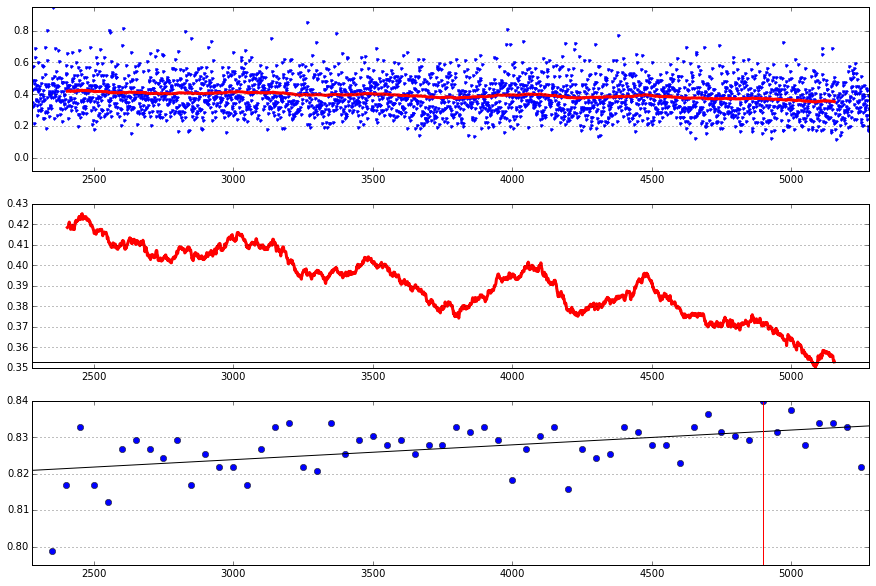

In [ ]:
# Train it
train_do(net_LSTM_1B_binary, no_improve_limit=56, plot_window=3000)

In [293]:
# See how you did
full_eval(net_LSTM_1B_binary, baseline_mean=87.5, baseline_std=0.5)

At best Dev performance...

Train accuracy (appoximate): 
1807/2000, 90.35% correct

Dev accuracy: 
696/825, 84.36% correct

Test accuracy: 
1475/1749, 84.33% correct


At end of training...

Train accuracy (appoximate): 
1896/2000, 94.8% correct

Dev accuracy: 
694/825, 84.12% correct

Test accuracy: 
1498/1749, 85.65% correct


Probability this score beats Sheng Tai baseline:
0.0%


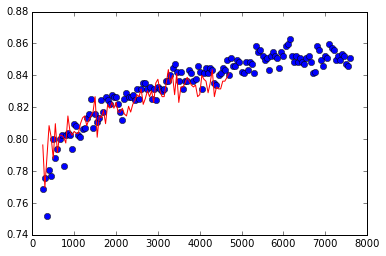

In [313]:
i1 = 5
d = net_LSTM_1_binary.dev_acc[i1:]
x = net_LSTM_1_binary.eval_dev_every*(np.arange(len(d))+i1)
plt.plot(x, d, 'o');
d = net_LSTM_1B_binary.dev_acc[i1:]
x = net_LSTM_1B_binary.eval_dev_every*(np.arange(len(d))+i1)
plt.plot(x, d, 'r');

# 1-layer vanilla LSTM (Fine-grained)

In [285]:
# Build a 1-layer vanilla LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(168, 0.5)]

# Build the LSTM "stack"
S = network_components.LSTM_stack(inp_dim, layer_specs, inp_dropout)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.soft_reader(S.out_dim, 5)

# Create the network
net_LSTM_1_fg = network(S, O, bi_flag=False, fine_grained=True, batch_size=25, eval_dev_every=50, alpha=0.005)

18.4299221039


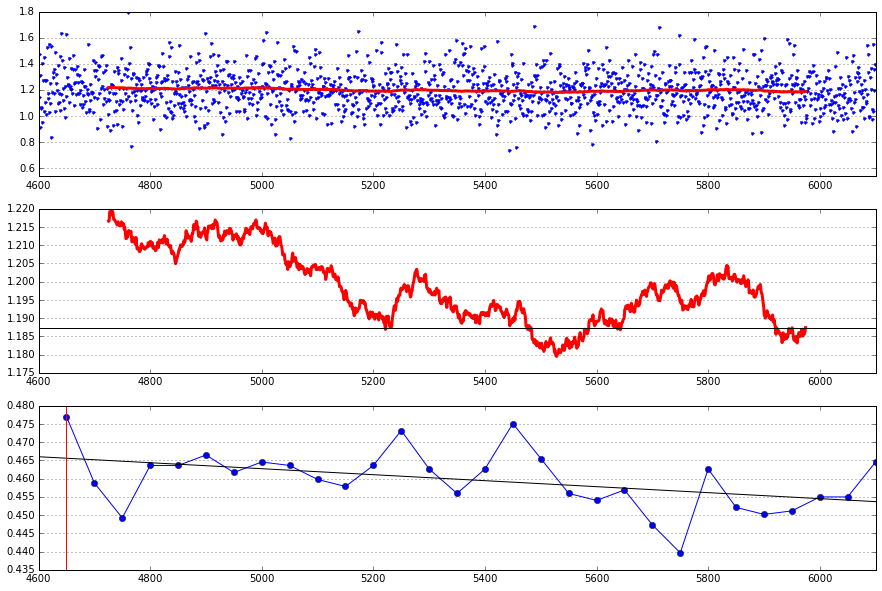

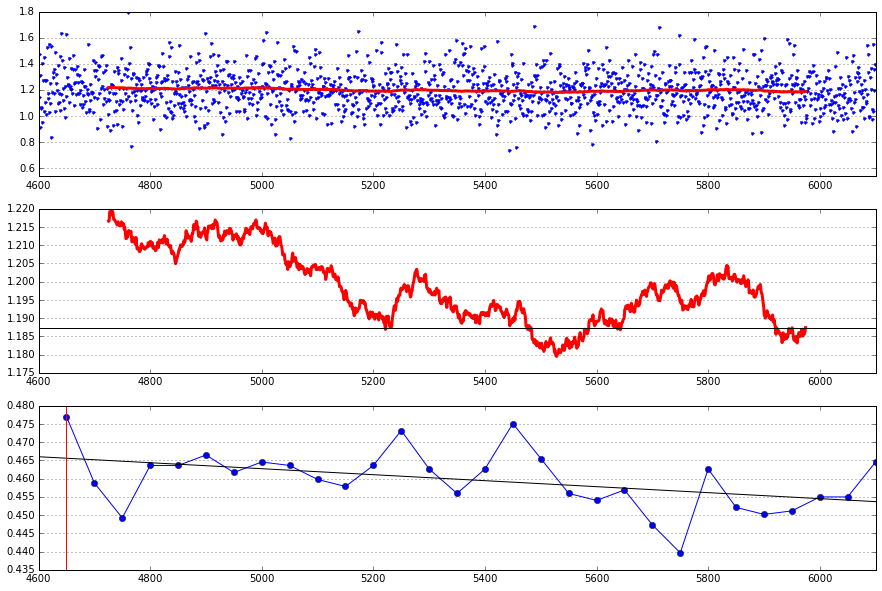

In [286]:
# Train it
train_do(net_LSTM_1_fg, no_improve_limit=28, plot_window=1500)

In [294]:
# See how you did
full_eval(net_LSTM_1_fg, baseline_mean=46.4, baseline_std=1.1)

At best Dev performance...

Train accuracy (appoximate): 
1159/2000, 57.95% correct

Dev accuracy: 
498/1044, 47.7% correct

Test accuracy: 
996/2125, 46.87% correct


At end of training...

Train accuracy (appoximate): 
1206/2000, 60.3% correct

Dev accuracy: 
485/1044, 46.46% correct

Test accuracy: 
1016/2125, 47.81% correct


Probability this score beats Sheng Tai baseline:
90.0%


# 1-layer Bi-directional LSTM (Fine-grained)

In [295]:
# Build a 1-layer vanilla LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(168, 0.5)]

# Build the LSTM "stack"
S = network_components.BiLSTM_stack(inp_dim, layer_specs, inp_dropout)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.soft_reader(S.out_dim, 5)

# Create the network
net_LSTM_1B_fg = network(S, O, bi_flag=True, fine_grained=True, batch_size=25, eval_dev_every=50, alpha=0.005)

36.1688990593


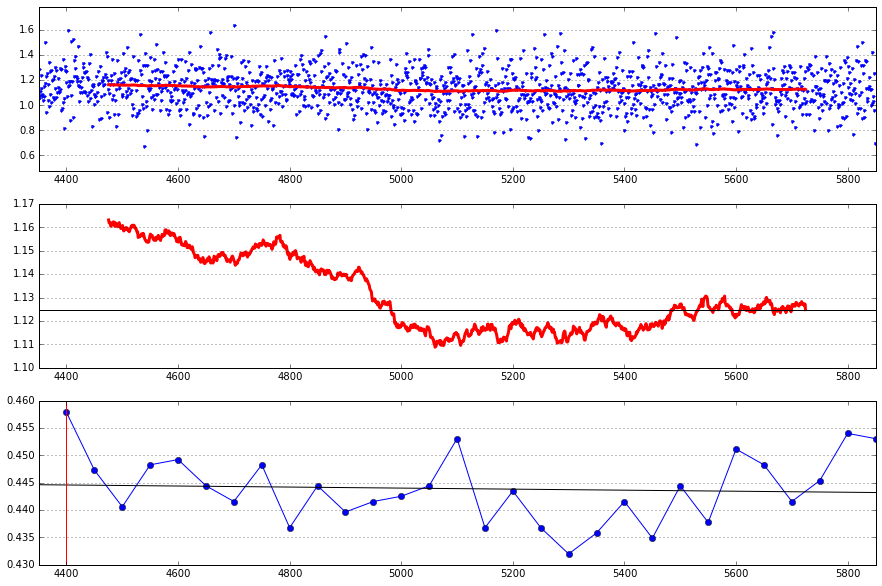

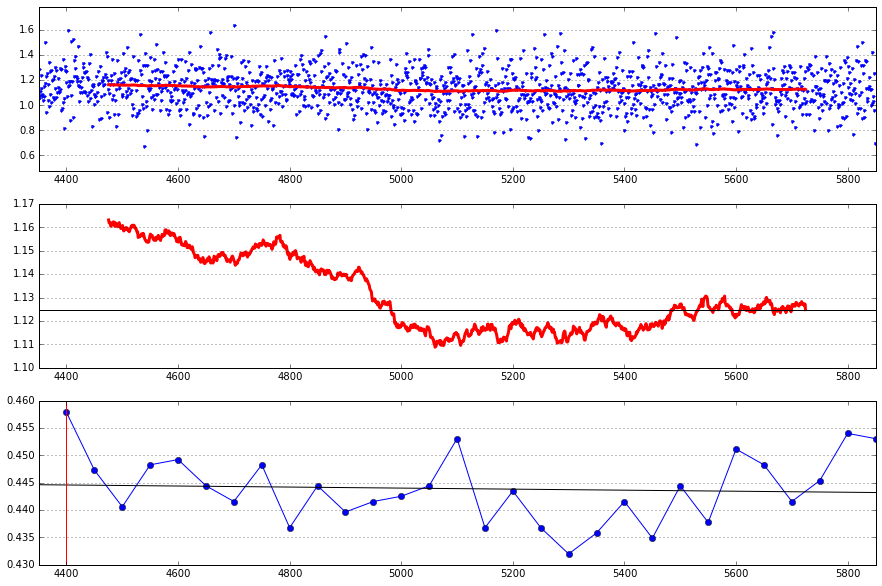

In [296]:
# Train it
train_do(net_LSTM_1B_fg, no_improve_limit=28, plot_window=1500)

In [297]:
# See how you did
full_eval(net_LSTM_1B_fg, baseline_mean=49.1, baseline_std=1.0)

At best Dev performance...

Train accuracy (appoximate): 
1311/2000, 65.55% correct

Dev accuracy: 
478/1044, 45.79% correct

Test accuracy: 
933/2125, 43.91% correct


At end of training...

Train accuracy (appoximate): 
1408/2000, 70.4% correct

Dev accuracy: 
473/1044, 45.31% correct

Test accuracy: 
966/2125, 45.46% correct


Probability this score beats Sheng Tai baseline:
0.0%


# 2-layer vanilla LSTM

In [ ]:
# Build a 2-layer vanilla LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(120, 0.5), (120, 0.5)]

# Build the LSTM "stack"
S = network_components.LSTM_stack(inp_dim, layer_specs, inp_dropout)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.single_class_sigmoid(S.out_dim)

# Create the network
net_LSTM_2_binary = network(S, O, bi_flag=False, fine_grained=False, batch_size=25, eval_dev_every=50, alpha=0.005)

In [ ]:
# Train it
train_do(net_LSTM_2_binary, no_improve_limit=28, plot_window=1500)

In [ ]:
# See how you did
full_eval(net_LSTM_2_binary, baseline_mean=86.3, baseline_std=0.6)

# 2-layer Bi-Directional LSTM

In [ ]:
# Build a 1-layer bi-directional LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(120, 0.5), (120, 0.5)]

# Build the LSTM "stack"
S = network_components.BiLSTM_stack(inp_dim, layer_specs, inp_dropout)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.single_class_sigmoid(S.out_dim)

# Create the network
net_LSTM_2B_binary = network(S, O, bi_flag=True, fine_grained=False, batch_size=25, eval_dev_every=50, alpha=0.005)

In [ ]:
# Train it
train_do(net_LSTM_2B_binary, no_improve_limit=28, plot_window=1500)

In [689]:
# See how you did
full_eval(net_LSTM_2B_binary, baseline_mean=86.3, baseline_std=0.6)

32.1945738792


In [594]:
m = T.tensor3()

M = T.concatenate([T.zeros([T.max(seq_lens), m.shape[1], m.shape[2]]), m], axis=0)

scan_outs, _ = theano.scan(
    fn=lambda offset, mat, L, maxL: T.transpose(mat[maxL + L - 1 - offset, :, T.arange(mat.shape[2])]),
    sequences=[T.arange(T.max(seq_lens))],
    outputs_info=[None],
    non_sequences=[M, seq_lens, T.max(seq_lens)])

In [595]:
tmpfun = theano.function([m, seq_lens], scan_outs)

In [596]:
tmp = np.arange(10).reshape([10, 1, 1])
tmp = tmp.repeat(5, axis=1).repeat(2, axis=2)

tmp_out = tmpfun(tmp, np.array([10, 4]).astype('int32'))

In [600]:
tmp

array([[[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]],

       [[2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2]],

       [[3, 3],
        [3, 3],
        [3, 3],
        [3, 3],
        [3, 3]],

       [[4, 4],
        [4, 4],
        [4, 4],
        [4, 4],
        [4, 4]],

       [[5, 5],
        [5, 5],
        [5, 5],
        [5, 5],
        [5, 5]],

       [[6, 6],
        [6, 6],
        [6, 6],
        [6, 6],
        [6, 6]],

       [[7, 7],
        [7, 7],
        [7, 7],
        [7, 7],
        [7, 7]],

       [[8, 8],
        [8, 8],
        [8, 8],
        [8, 8],
        [8, 8]],

       [[9, 9],
        [9, 9],
        [9, 9],
        [9, 9],
        [9, 9]]])

In [601]:
tmp_out

array([[[ 9.,  3.],
        [ 9.,  3.],
        [ 9.,  3.],
        [ 9.,  3.],
        [ 9.,  3.]],

       [[ 8.,  2.],
        [ 8.,  2.],
        [ 8.,  2.],
        [ 8.,  2.],
        [ 8.,  2.]],

       [[ 7.,  1.],
        [ 7.,  1.],
        [ 7.,  1.],
        [ 7.,  1.],
        [ 7.,  1.]],

       [[ 6.,  0.],
        [ 6.,  0.],
        [ 6.,  0.],
        [ 6.,  0.],
        [ 6.,  0.]],

       [[ 5.,  0.],
        [ 5.,  0.],
        [ 5.,  0.],
        [ 5.,  0.],
        [ 5.,  0.]],

       [[ 4.,  0.],
        [ 4.,  0.],
        [ 4.,  0.],
        [ 4.,  0.],
        [ 4.,  0.]],

       [[ 3.,  0.],
        [ 3.,  0.],
        [ 3.,  0.],
        [ 3.,  0.],
        [ 3.,  0.]],

       [[ 2.,  0.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 2.,  0.]],

       [[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
  

In [735]:
np.mean( np.random.normal(86.3, 0.6, 100) < 85.31 )*100

5.0

In [490]:
i_seq, s_len, t, idx = pull_data(data_dict['dev'], 1)

print data_dict['dev_RT'][idx][0]
print 'True score: {}'.format(data_dict['dev_RT'][idx][1])
print 'Est. score: {}'.format(guess(i_seq, s_len)[0])
print 'Cost: {}'.format(cfun(i_seq, s_len, t))

The film is powerful , accessible and funny .
True score: 0.83333
Est. score: 0.994527171021
Cost: 0.00548785977346
